# Prétraitement : Transformée de Fourier

Cette partie est dédiée à l'étude du prétraitement des données temporelles par transformation de Fourier (rapide).

## Visualisation des signaux

Voici quelques sorties graphiques de lignes temporelles bien précises correspondant à une seule activité chacune, ainsi que leurs analyses spectrales correspondantes

In [1]:
%matplotlib inline

from utils.io import MergeAllInertialData, readFile
from utils.tools import plot_matrix_decomp_ACP, biclustering_impact_viewer
from utils.scoring import get_best_score, Alt_CH_biclust, Alt_silhouette_biclust, cluster_activity_score, evaluate_clustering
from fourier_analysis import analysis_subplot, draw_fft_subplot, time_and_freq_analysis_plots
import numpy as np
from scipy.fftpack import fft
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn.cluster
from sklearn.decomposition import PCA
import json
from utils.io import readFile, MergeBodyAcc, MergeBodyGyro

########### Time domain data visualization ###########
Plotting graphics ....................................


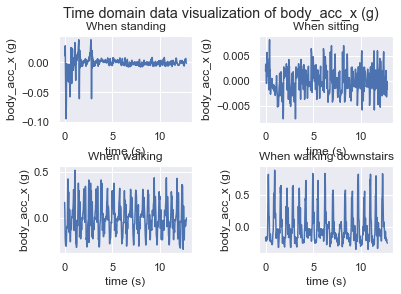

########### Freq domain data visualization ###########
Plotting graphics ....................................


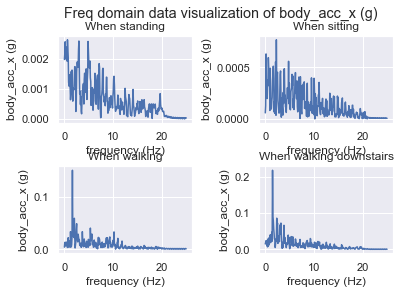

########### Time domain data visualization ###########
Plotting graphics ....................................


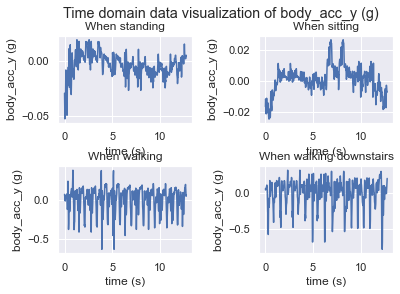

########### Freq domain data visualization ###########
Plotting graphics ....................................


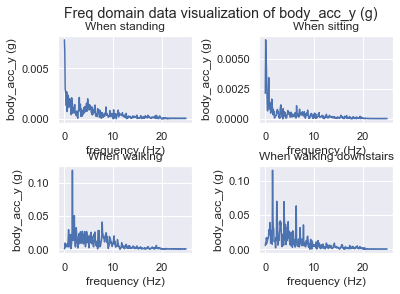

########### Time domain data visualization ###########
Plotting graphics ....................................


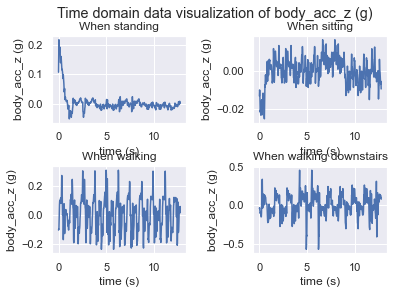

########### Freq domain data visualization ###########
Plotting graphics ....................................


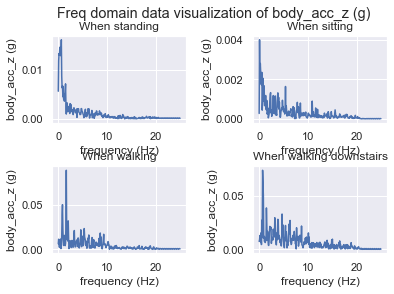

########### Time domain data visualization ###########
Plotting graphics ....................................


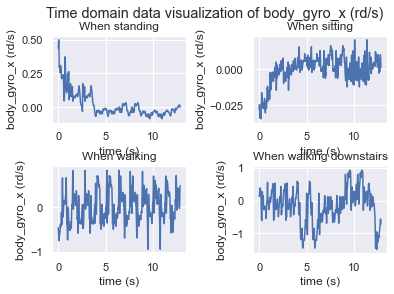

########### Freq domain data visualization ###########
Plotting graphics ....................................


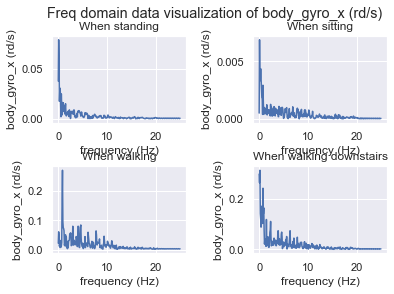

########### Time domain data visualization ###########
Plotting graphics ....................................


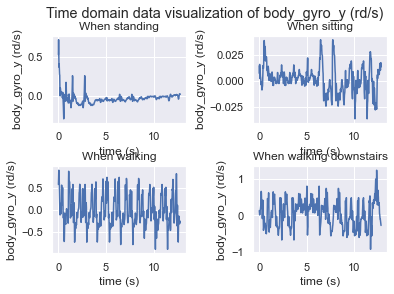

########### Freq domain data visualization ###########
Plotting graphics ....................................


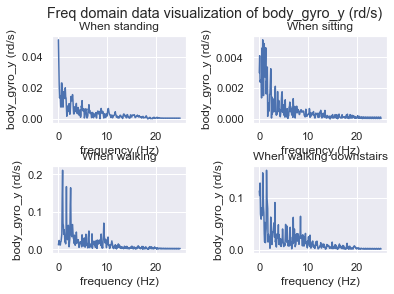

########### Time domain data visualization ###########
Plotting graphics ....................................


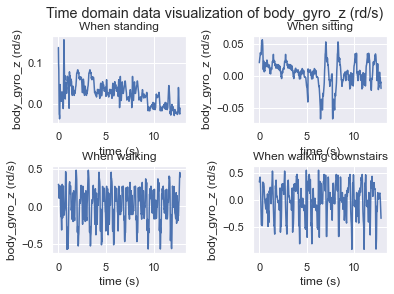

########### Freq domain data visualization ###########
Plotting graphics ....................................


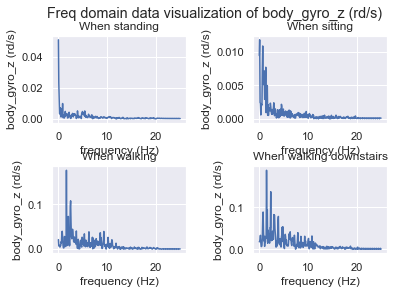

In [2]:
sn.set()

# Analyse des signaux temporels

body_acc = MergeBodyAcc()
body_gyro = MergeBodyGyro()

n_row, n_col, _ = body_acc.shape

Dt = 2.56  # s

n = 5   # nb plages

main_arrays = [body_acc, body_gyro]
y_labels = ["body_{}_{} ({})".format(key, axis, unit)
            for key, unit in [("acc", "g"), ("gyro", "rd/s")] for axis in ["x", "y", "z"]]
params = [{"array": main_arrays[i//3][:, :, i % 3], "y_label":y_labels[i]} for i in range(6)]

for d in params:
    array = d["array"]
    y_label = d["y_label"]
    time_and_freq_analysis_plots(array, y_label, n, Dt, n_col)

## PCA reduction

Puisque pour chaque expérience 6 lignes temporelles sont à étudier, on privilégiera l'analyse en composantes principales pour étudier ces signaux multivariés pour ne garder qu'une projection sur la composante la plus explicative.

In [3]:
inertial_data = MergeAllInertialData()    # Retrieve all the time series

n_row, n_col, _ = inertial_data.shape     # shape : (n_row, n_col, 6)

Dt = 2.56  # s

f_ech = n_col/Dt

ACP components : 5
Variance ratios :  [0.43173176 0.27393004 0.14901276 0.09016785 0.0316259 ]
ACP components : 1
Variance ratios :  [0.43173176]
Principal vector used :  [-0.01181191  0.01037684 -0.00620887 -0.88804452  0.45271485  0.078361  ]
New shape (reduced) :  (10299, 128)


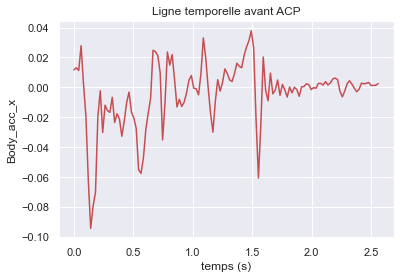

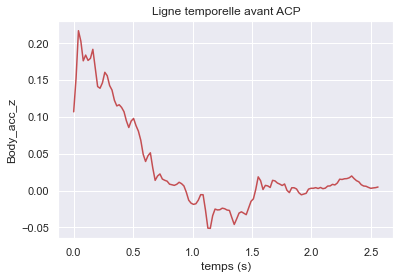

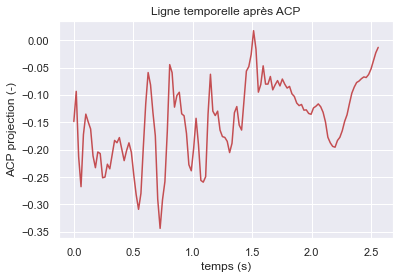

In [4]:
%matplotlib inline
acp = PCA(n_components=5, svd_solver='full')   # Creation of a  PCA reduction solver to reduce the 6 components to the first most explicative eigenvector

acp.fit(inertial_data[:, 0, :])                # Fit the ACP on the data corresponding to t=0
print("ACP components :", acp.n_components)

ratios = acp.explained_variance_ratio_
print("Variance ratios : ", ratios)

acp = PCA(n_components=1, svd_solver='full')

new_arrays = []
acp.fit(inertial_data[:, 0, :])
print("ACP components :", acp.n_components)

ratios = acp.explained_variance_ratio_
print("Variance ratios : ", ratios)

principal_vector = acp.components_[0]
print("Principal vector used : ", principal_vector)

for j in range(n_col):
    # print(inertial_data[:, j, :].shape)

    # Uncomment next line to make adaptative eigenvectors
    # acp.fit(inertial_data[:, j, :])
    new_array = acp.transform(inertial_data[:, j, :])
    # print(new_array.shape)
    new_arrays.append(new_array)

new_inertial = np.concatenate(new_arrays, axis=1)

print("New shape (reduced) : ", new_inertial.shape)

ts = np.linspace(0, 2.56, new_inertial.shape[1])
xs = new_inertial[0, :]

xs0 = inertial_data[0, :, 0]

plt.plot(ts, xs0, 'r')
plt.title("Ligne temporelle avant ACP")
plt.xlabel("temps (s)")
plt.ylabel("Body_acc_x")
plt.show()

xs1 = inertial_data[0, :, 2]

plt.plot(ts, xs1, 'r')
plt.title("Ligne temporelle avant ACP")
plt.xlabel("temps (s)")
plt.ylabel("Body_acc_z")
plt.show()

plt.plot(ts, xs, 'r')
plt.title("Ligne temporelle après ACP")
plt.xlabel("temps (s)")
plt.ylabel("ACP projection (-)")
plt.show()

Le taux d'explicativité du premier vecteur principal est de 43% et celui-ci prend bien en compte toutes les 6 composantes. Nous utiliserons ce vecteur par la suite pour projeter les données des 6 différents degrés de liberté du smartphone pour ainsi avoir un tableau en 2 dimensions sur lequel effectuer un CoClustering. Nous analyserons l'impact de ce CoClustering après prétraitement par transformée de Fourier.

## CoClustering : Spectral biclustering sur données prétraitées

Ci-dessous la matrice des lignes temporelles après réduction ACP. On remarque sur chaque ligne une ligne temporelle plutôt cohérente et régulière. Cela est dû au fait que l'on ait utilisé une seule ACP à t=0 et non une ACP à chaque temps t.

Shape of the fft matrix :  (10299, 64)


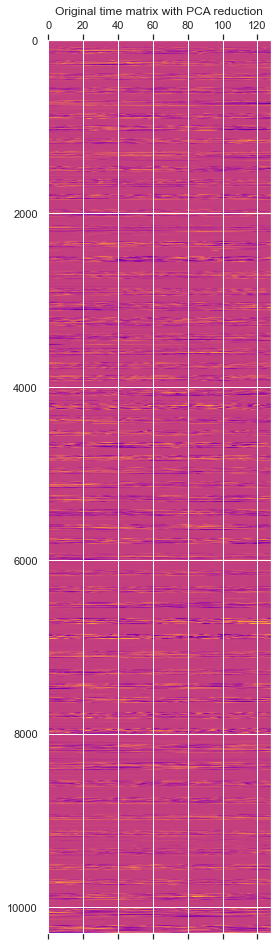

In [5]:
C = new_inertial

F = 2*np.abs(fft(new_inertial, axis=1)[:, :n_col//2])/n_col  # Performing fft on the time axis

print("Shape of the fft matrix : ", F.shape)

fs = np.linspace(0, f_ech/2, F.shape[1])

# computing a spectral  biclustering

row_clusters, col_clusters = 6, 4

plt.matshow(C, cmap=plt.get_cmap(name='plasma'), aspect='auto')
plt.title("Original time matrix with PCA reduction")
plt.show()

Analysons maintenant l'impact de la FFT et du CoClustering sur la matrice après application de la transormée de Fourier rapide et d'un CoClustering avec 6 classes en ligne et 4 classes en colonne.

(10299, 64)


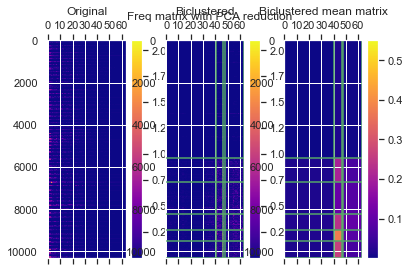

In [7]:
cluster = biclustering_impact_viewer(F, row_clusters, col_clusters, "Freq matrix with PCA reduction")

Analysons le contenu de chaque cluster :

In [28]:
y_test = readFile("working_data/test/y_test.txt")

subject_test = readFile("working_data/test/subject_test.txt")


# X_train = readFile("../UCI HAR Dataset/train/X_train.txt")

y_train = readFile("working_data/train/y_train.txt")

subject_train = readFile("working_data/train/subject_train.txt")


subjects = np.concatenate((subject_train, subject_test))
activities = np.concatenate((y_test, y_train))

# X = np.concatenate((X_train, X_test))

##################### CLUSTERS SCORES #####################

cluster_activities = evaluate_clustering(activities, cluster)
cluster_act_score = cluster_activity_score(activities, cluster)

for i in range(row_clusters):
    print("Activities in row {} : ".format(i), cluster_activities[i, 0])
print("Cluster mean activity score : ", cluster_act_score)

Activities in row 0 :  {5: 0.33519452449566634, 4: 0.31628242074926977, 6: 0.3411383285302481, 3: 0.0023414985590778097, 2: 0.002521613832853026, 1: 0.002521613832853026}
Activities in row 1 :  {3: 0.3729281767955817, 2: 0.24999999999999944, 1: 0.36878453038674186, 6: 0.008287292817679558}
Activities in row 2 :  {1: 0.10051993067591014, 3: 0.3362218370883869, 2: 0.5233968804159417, 5: 0.01819757365684575, 4: 0.00606585788561525, 6: 0.015597920277296356}
Activities in row 3 :  {1: 0.8252299605781686, 2: 0.07030223390275948, 3: 0.08935611038107764, 4: 0.001314060446780552, 5: 0.01182654402102497, 6: 0.0019710906701708277}
Activities in row 4 :  {3: 0.509615384615383, 2: 0.45192307692307554, 1: 0.038461538461538464}
Activities in row 5 :  {1: 0.05925030229746065, 3: 0.4038694074969782, 2: 0.4873035066505456, 4: 0.014510278113663842, 6: 0.027811366384522376, 5: 0.007255139056831923}
Cluster mean activity score :  0.4555782114768335


Certains clusters en ligne ont bien capturé certains types d'activités comme celle avec 82% d'activité 1 et celle avec les activités 2 et 3 à parts égales (walking up/downstairs). Les labels des activités étant listés ci-dessous :
- 1 WALKING
- 2 WALKING_UPSTAIRS
- 3 WALKING_DOWNSTAIRS
- 4 SITTING
- 5 STANDING
- 6 LAYING

Les activités "S'asseoir" et "Se lever" se rencontrent dans certains clusters car selon l'intervalle d'enregistrement l'activité change. Il peut être intéressant de mettre plusieurs activités par ligne pour voir si le coclustering permet des les distinguer.

Le CoClustering a l'air assez efficace après prétraitement par analyse spectrale et réduction ACP. On peut atteindre de très bons scores comme on l'a vu et si l'on regoupe les activités comme "S'asseoir" et "Se lever" qui sont des actions de transition entre 2 mêmes états et les activités "Être allongé" et "Être assis", on peut également atteindre des scores de 90% par cluster en ligne.

Etudions maintenant le contenu spectral de chaque cluster en colonne. Les résultas sont en Hz.

In [30]:
from fourier_raw_coclust_acp import freq_stat_analysis


stat_analysis = freq_stat_analysis(fs, cluster)

for j in range(col_clusters):
    print("Column {} : mean = {}, std = {}".format(j, stat_analysis[j]["mean"], stat_analysis[j]["std"]))


Column 0 : mean = 4.5436507936507935, std = 2.322276334145882
Column 1 : mean = 16.865079365079364, std = 4.8098883162901345
Column 2 : mean = 0.7936507936507936, std = 0.0
Column 3 : mean = 0.0, std = 0.0


On remarque que le clustering distingue les activités selon des groupes de fréquences bien distincts et qui semblent permettre une bonne discrimination des activités. L'une des colonnes se concentrant sur une fréquence proche d'un fondamental commun pour les activités "à basse fréquence" i.e. presque immobiles. Le clustering est alors efficace en ce qui concerne la distinction des activités dites immobiles de celles qui sont mobiles, ce qui justifie les proprotions des activités dans les clusters.

Un grid search sur le nombre optimal de cluster en ligne et en colonne avec les scores de Calinski-Harabasz et de Silhouette donne un découpage optimal pour 30 clusters en ligne au moins et 2 clusters en colonne. Le nombre de clusters en ligne est trop grand pour être interprétable donc il serait mieux de choisir un nombre de clusters en ligne égal à 4 car il s'agit d'un maximum local du score de Silhouette.

In [37]:
row_clusters, col_clusters = 4, 3

cluster = biclustering_impact_viewer(F, row_clusters, col_clusters, "Freq matrix with PCA reduction")

(10299, 64)


In [40]:
##################### CLUSTERS SCORES #####################

cluster_activities = evaluate_clustering(activities, cluster)
cluster_act_score = cluster_activity_score(activities, cluster)

for i in range(row_clusters):
    print("Activities in row {} : ".format(i), cluster_activities[i, 0])
print("Cluster mean activity score : ", cluster_act_score)
print()

stat_analysis = freq_stat_analysis(fs, cluster)

for j in range(col_clusters):
    print("Column {} : mean = {}, std = {}".format(j, stat_analysis[j]["mean"], stat_analysis[j]["std"]))

Activities in row 0 :  {1: 0.10051993067591014, 3: 0.3362218370883869, 2: 0.5233968804159417, 5: 0.01819757365684575, 4: 0.00606585788561525, 6: 0.015597920277296356}
Activities in row 1 :  {5: 0.33519452449566634, 4: 0.31628242074926977, 6: 0.3411383285302481, 3: 0.0023414985590778097, 2: 0.002521613832853026, 1: 0.002521613832853026}
Activities in row 2 :  {1: 0.051224944320712756, 3: 0.4446919079435837, 2: 0.47364513734224833, 4: 0.008908685968819597, 6: 0.017074981440237558, 5: 0.004454342984409799}
Activities in row 3 :  {1: 0.678094390026701, 3: 0.18076580587711513, 2: 0.12822796081923352, 4: 0.0008904719501335708, 5: 0.008014247551202138, 6: 0.004007123775601069}
Cluster mean activity score :  0.4523740168948357

Column 0 : mean = 12.89042498719918, std = 7.112476615793996
Column 1 : mean = 0.0, std = 0.0
Column 2 : mean = 0.7936507936507936, std = 0.0


Les résultats avec ce découpage ne sont pas plus intéressants que le premier, d'autant plus que l'on perd le cluster en ligne avec plus de 80% de discrimination.

## Biclustering avec plusieurs activités par ligne

Dans la partie précédente une seule activité a été mise par ligne. Il peut être intéressant de mettre plusieurs activités par ligne afin de pouvoir les regouper en colonne et permettre un regroupement des individus selon le type d'activités qu'ils réalisent. 

Un problème apparaît alors si l'on ne laisse que du contenu fréquentiel dans le tableau en 2D car si l'on effectue un coclustering sur un tableau à contenu fréquentiel avec plusieurs activités par ligne, celui-ci regroupera les basses fréquences des différentes activités dans un cluster et idem pour les autres groupes de fréquences. Nous n'aurons pas alors une discrimination selon le type d'activité en colonne mais toujours selon le contenu fréquentiel.

Il faudrait tout d'abord vérifier cette hypothèse en interprétant le résultat obtenu et trouver une parade à ce phénomène.
Cet objectif tient donc lieu d'ouverture pour cette partie qu'est le prétraitement par FFT.